In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from matplotlib import pyplot as plt
import os
import gc
from load_dataset import get_orth_dataloader
import utils
import lightning.pytorch as pl
import shutil
from IPython.display import clear_output


c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train, test = get_orth_dataloader('data/AA_orth.joblib',shuffle=False, train_size=0.8, batch_size=64)

In [12]:
random_matrices_orth = joblib.load('data/AA_random_matrices_orth.joblib')

In [3]:
class Encoder(nn.Module):
    def __init__(self, out_dim,in_channels, latent_dim: int, conv_k = 3, conv_s=1, conv_p=1, pool_k=0, pool_s=1,
                 use_batch_norm=False, dropout_rate = 0,
                 activation_function = nn.ReLU):

        super().__init__()
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        self.in_channels = in_channels
        self.use_batch_norm = use_batch_norm
        self.layers = nn.ModuleList()


        for i in range(len(self.in_channels)-1):
            self.layers.append(nn.Conv1d(self.in_channels[i], self.in_channels[i+1],  kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            self.layers.append(activation_function())
            if use_batch_norm:
                self.layers.append(nn.BatchNorm1d(self.in_channels[i+1]))
            self.layers.append(nn.Dropout(p=dropout_rate))

            
        self.conv_net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(int(out_dim* self.in_channels[-1]), latent_dim)


    def forward(self, x):
        out = self.conv_net(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [4]:
class Decoder(nn.Module):
    def __init__(self, out_dim, in_channels, latent_dim: int, conv_k = 3, conv_s=1, conv_p=1, pool_k=2, pool_s=2,
                 use_batch_norm=False, dropout_rate = 0,
                 activation_function = nn.ReLU):
        super().__init__()
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s

        self.in_channels = in_channels
        self.layers = nn.ModuleList()
        self.latent_dim = latent_dim


        for i in range(len(self.in_channels)-1):
            self.layers.append(nn.ConvTranspose1d (self.in_channels[i], self.in_channels[i+1],  kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            self.layers.append(activation_function())
            if use_batch_norm:
                self.layers.append(nn.BatchNorm1d(self.in_channels[i+1]))
            self.layers.append(nn.Dropout(p=dropout_rate))
            
        self.layers.append(nn.Tanh())
        self.conv_net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(latent_dim, int(out_dim*in_channels[0]))
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], self.in_channels[0], -1)
        x = self.conv_net(x)
        return x

In [5]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        data_shape: tuple,
        in_channels,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        conv_k = 3, conv_s=1, conv_p=1, pool_k=0, pool_s=1,
        use_batch_norm=False, dropout_rate = 0,
        activation_function = nn.ReLU, optimizer = optim.Adagrad, loss_func = nn.MSELoss(), lr= 0.0001
    ):
        super().__init__()
        self.in_channels = in_channels
        self.lr = lr
        self.data_shape = data_shape
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.activation_function = activation_function
        out_dim = data_shape[1]


        for _ in range(len(in_channels)-1):
            out_dim = self.compute_dim(out_dim, self.conv_k, self.conv_s, self.conv_p, self.pool_k, self.pool_s)
        
        in_channels_reversed = in_channels[::-1]
        self.encoder = encoder_class(out_dim, in_channels, latent_dim, conv_k, conv_s, conv_p, pool_k, pool_s, use_batch_norm, dropout_rate, activation_function)
        self.decoder = decoder_class(out_dim, in_channels_reversed, latent_dim, conv_k, conv_s, conv_p, pool_k, pool_s, use_batch_norm, dropout_rate, activation_function)
        self.out_dim = out_dim
        
        
        self.training_epoch_mean = []
        self.current_training_epoch_loss = []
        self.training_step_loss = []
        self.validation_epoch_mean = []
        self.current_validation_epoch_loss = []
        self.validation_step_loss = []
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x,_ = batch  # We do not need the labels
        preds = self.forward(x)
        loss = self.loss_func(preds, x)
        return loss

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.current_training_epoch_loss.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.current_validation_epoch_loss.append(loss.detach().cpu().numpy())

    def on_train_epoch_end(self):
        epoch_loss = np.mean(self.current_training_epoch_loss)
        self.training_step_loss += self.current_training_epoch_loss
        self.training_epoch_mean.append(epoch_loss)
        self.log("train_epoch_loss", epoch_loss, prog_bar=True)
        self.current_training_epoch_loss.clear()

    def on_validation_epoch_end(self):
        epoch_loss = np.mean(self.current_validation_epoch_loss)
        self.validation_step_loss += self.current_validation_epoch_loss
        self.validation_epoch_mean.append(epoch_loss)
        self.log("validation_epoch_loss", epoch_loss, prog_bar=True)
        self.current_validation_epoch_loss.clear()

    def compute_dim(self, dim, conv_k, conv_s, conv_p, pool_k, pool_s):
        dim = np.floor(((dim - conv_k + 2 * conv_p)/conv_s)+1)
        return dim

In [6]:
class Item():
    def __init__(self, name, model, correct_prediction, num_elem_tested):
        components = name.split('_')
        self.name = name
        self.model = model
        self.channels, self.latent_dim, self.activation_function, self.optimizer, self.loss_function, self.dropout_rate, self.batch_norm = components
        self.correct_prediction = correct_prediction

        #To change 
        self.conv_k = 3
        self.conv_s = 1
        self.conv_p = 1
        self.pool_k = 0
        self.pool_s = 1
        self.num_elem_tested = num_elem_tested

In [9]:
models = {}
for model in os.listdir("models/Autoencoder1D"):
    models[model] = joblib.load("models/Autoencoder1D/"+model)

In [14]:
for aa, vec in random_matrices_orth.items():
    random_matrices_orth[aa] = vec.numpy()

In [11]:
items = []
for name, model in models.items():
    model.cpu()
    o= None
    seqs= []
    for t in test:
        o = model(t[0]).detach().cpu().numpy()
        seqs = t[1] 
        break
    total = utils.batch_correct_reconstructed_amino_acid(seqs, o, random_matrices_orth, 1965)[0]
    items.append(Item(name, model, total, len(seqs)*1965))

In [ ]:
items = joblib.load('evaluation.joblib')

In [13]:
best = max(items, key=lambda x: x.correct_prediction)

In [14]:
best.correct_prediction

123090

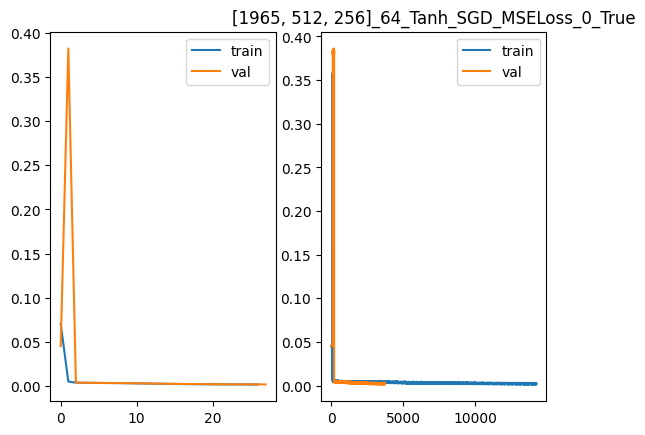

In [15]:
plt.subplot(1,2,1)
plt.plot(range(len(best.model.training_epoch_mean)), best.model.training_epoch_mean, label='train')
plt.plot(range(len(best.model.validation_epoch_mean)), best.model.validation_epoch_mean, label='val')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(best.model.training_step_loss)), best.model.training_step_loss, label='train')
plt.plot(range(len(best.model.validation_step_loss)), best.model.validation_step_loss, label='val')

plt.legend()
plt.title(name)
plt.show()

In [7]:
best = joblib.load('models/best_model.joblib')

In [26]:
def get_correct_preds(model, dataloader, random_matrices_orthogonal):
    preds = 0
    for batch in dataloader:
        mats, seqs = batch
        outputs = model(mats).detach().cpu().numpy()
        preds += utils.batch_correct_reconstructed_amino_acid(seqs, outputs, random_matrices_orthogonal, 1965)[0]
    return preds

In [27]:
correct_preds_train = get_correct_preds(best, train, random_matrices_orth)
correct_preds_test = get_correct_preds(best, test, random_matrices_orth)

In [28]:
num_seq_train = sum([len(x[0]) for x in train])
num_seq_test = sum([len(x[0]) for x in test])

In [29]:
# correct number of prediction and accuracy
# 1965 = longuest sequence, num_seq_* = number of sequence
print(correct_preds_train, correct_preds_train/(num_seq_train*1965))
print(correct_preds_test, correct_preds_test/(num_seq_test*1965))

66689099 0.9754116449254726
16680616 0.9758435572279227


In [22]:
joblib.dump(best.model, 'best_model.joblib')

['best_model.joblib']

In [31]:
best

Autoencoder(
  (loss_func): MSELoss()
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv1d(1965, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Tanh()
      (8): Dropout(p=0, inplace=False)
    )
    (conv_net): Sequential(
      (0): Conv1d(1965, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Tanh()
      (8): Dropout(p=0, inplace=False)
    )
    (fc): Linear(in_features=2816, out_features=1024, bias=True)
  )
  (decoder): Decoder(
 